# 某超市在北美地区的零售数据分析

## 需求和目的
---
* 对某超市在北美地区四年（2014-2017）的销售数据进行 “场、货、人”分析，并部分提出针对性建议。
* 场：对整体运营情况，包括销售额、销量、利润、客单价、市场布局等情况进行分析；
* 货：对商品销售种类、畅销商品、滞销商品等情况进行分析；
* 人：对客户类型、客户状态、复购率、回购率等用户行为，并构建RFM模型进行分析。

## 导入相关库并加载数据

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "darkgrid")

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
data = pd.read_excel('Superstore_2014-2017.xlsx')
# 过滤出北美地区的数据
data = data.loc[data['Market'] == "USCA"]
print(data.shape)
data.head()

(10378, 24)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Postal Code,City,...,Product ID,Product Name,Sub-Category,Category,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
6333,31297,CA-2016-CG12520140-42683,2016-11-09,2016-11-12,Second Class,CG-125201408,Claire Gute,Consumer,42420.0,Henderson,...,FUR-BO-3645,Bush Somerset Collection Bookcase,Bookcases,Furniture,261.9600,2,0.00,41.9136,54.10,Critical
6334,31298,CA-2016-CG12520140-42683,2016-11-09,2016-11-12,Second Class,CG-125201408,Claire Gute,Consumer,42420.0,Henderson,...,FUR-CH-4650,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",Chairs,Furniture,731.9400,3,0.00,219.5820,161.71,Critical
6335,31299,CA-2016-DV13045140-42534,2016-06-13,2016-06-17,Second Class,DV-130451404,Darrin Van Huff,Corporate,90036.0,Los Angeles,...,OFF-LA-5976,Self-Adhesive Address Labels for Typewriters b...,Labels,Office Supplies,14.6200,2,0.00,6.8714,1.47,High
6336,31300,US-2015-SO20335140-42288,2015-10-11,2015-10-18,Standard Class,SO-203351408,Sean O'Donnell,Consumer,33311.0,Fort Lauderdale,...,FUR-TA-3560,Bretford CR4500 Series Slim Rectangular Table,Tables,Furniture,957.5775,5,0.45,-383.0310,79.69,Low
6337,31301,US-2015-SO20335140-42288,2015-10-11,2015-10-18,Standard Class,SO-203351408,Sean O'Donnell,Consumer,33311.0,Fort Lauderdale,...,OFF-ST-4059,Eldon Fold 'N Roll Cart System,Storage,Office Supplies,22.3680,2,0.20,2.5164,2.83,Low


## 数据预处理

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10378 entries, 6333 to 50546
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Row ID          10378 non-null  int64         
 1   Order ID        10378 non-null  object        
 2   Order Date      10378 non-null  datetime64[ns]
 3   Ship Date       10378 non-null  datetime64[ns]
 4   Ship Mode       10378 non-null  object        
 5   Customer ID     10378 non-null  object        
 6   Customer Name   10378 non-null  object        
 7   Segment         10378 non-null  object        
 8   Postal Code     9994 non-null   float64       
 9   City            10378 non-null  object        
 10  State           10378 non-null  object        
 11  Country         10378 non-null  object        
 12  Region          10378 non-null  object        
 13  Market          10378 non-null  object        
 14  Product ID      10378 non-null  object        
 15 

In [4]:
data.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit,Shipping Cost
count,10378.000000,9994.000000,10378.000000,10378.000000,10378.000000,10378.000000,10378.000000
mean,36670.677394,55190.379428,227.801988,3.729620,0.150423,29.313395,23.844423
std,3467.852197,32063.693350,615.028077,2.231588,0.204731,230.976459,58.410903
min,31297.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000,1.010000
25%,33891.250000,23223.000000,17.484000,2.000000,0.000000,1.846800,1.830000
50%,36485.500000,56430.500000,54.900000,3.000000,0.100000,8.772250,5.140000
75%,39079.750000,90008.000000,208.370000,5.000000,0.200000,29.643200,19.732500
max,51106.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000,933.570000


In [5]:
data.rename(columns = lambda x: x.replace(' ', '_').replace('-', '_'), inplace=True)

In [6]:
data.columns

Index(['Row_ID', 'Order_ID', 'Order_Date', 'Ship_Date', 'Ship_Mode',
       'Customer_ID', 'Customer_Name', 'Segment', 'Postal_Code', 'City',
       'State', 'Country', 'Region', 'Market', 'Product_ID', 'Product_Name',
       'Sub_Category', 'Category', 'Sales', 'Quantity', 'Discount', 'Profit',
       'Shipping_Cost', 'Order_Priority'],
      dtype='object')

In [7]:
# 增加年份和月份
data['year'] = data["Order_Date"].dt.year
data['month'] = data['Order_Date'].values.astype('datetime64[M]')

In [8]:
data.isnull().sum()/len(data)

Row_ID            0.000000
Order_ID          0.000000
Order_Date        0.000000
Ship_Date         0.000000
Ship_Mode         0.000000
Customer_ID       0.000000
Customer_Name     0.000000
Segment           0.000000
Postal_Code       0.037001
City              0.000000
State             0.000000
Country           0.000000
Region            0.000000
Market            0.000000
Product_ID        0.000000
Product_Name      0.000000
Sub_Category      0.000000
Category          0.000000
Sales             0.000000
Quantity          0.000000
Discount          0.000000
Profit            0.000000
Shipping_Cost     0.000000
Order_Priority    0.000000
year              0.000000
month             0.000000
dtype: float64

In [9]:
# Postal_Code为邮编信息，其信息利用价值不大，可直接删除该列
data.drop(["Postal_Code"], axis=1, inplace=True)

In [10]:
# 查看是否存在重复值
data.duplicated().sum()

0

## 数据分析

### 整体销售分析

In [11]:
# 构造销售数据，其包含下单日期、销售额、销量、利润、年份、月份
sales_data = data[['Order_Date', 'Sales', 'Quantity', 
                   'Profit', 'year', 'month']]
sales_data.head()

,Order_Date,Sales,Quantity,Profit,year,month
6333,2016-11-09,261.9600,2,41.9136,2016,2016-11-01
6334,2016-11-09,731.9400,3,219.5820,2016,2016-11-01
6335,2016-06-13,14.6200,2,6.8714,2016,2016-06-01
6336,2015-10-11,957.5775,5,-383.0310,2015,2015-10-01
6337,2015-10-11,22.3680,2,2.5164,2015,2015-10-01


In [12]:
# 按照年份、月份对销售数据进行分组求和
sales_year = sales_data.groupby(['year', 'month']).sum()
sales_year.head()

Sales  Quantity     Profit
year month                                     
2014 2014-01-01  14276.739       284  2455.5911
     2014-02-01   8856.579       221  1079.7366
     2014-03-01  53842.526       561   841.6909
     2014-04-01  28461.537       534  3517.8256
     2014-05-01  29588.817       527  4393.4305

In [13]:
# 将销售数据拆分为一年为一个表
year_2014 = sales_year.loc[(2014, slice(None)),:].reset_index()
year_2015 = sales_year.loc[(2015, slice(None)),:].reset_index()
year_2016 = sales_year.loc[(2016, slice(None)),:].reset_index()
year_2017 = sales_year.loc[(2017, slice(None)),:].reset_index()
# 查看每年前5行数据
print(year_2014.head())
print(year_2015.head())
print(year_2016.head())
print(year_2017.head())

   year      month      Sales  Quantity     Profit
0  2014 2014-01-01  14276.739       284  2455.5911
1  2014 2014-02-01   8856.579       221  1079.7366
2  2014 2014-03-01  53842.526       561   841.6909
3  2014 2014-04-01  28461.537       534  3517.8256
4  2014 2014-05-01  29588.817       527  4393.4305
   year      month       Sales  Quantity     Profit
0  2015 2015-01-01  18174.0756       236 -3281.0070
1  2015 2015-02-01  12737.5470       260  2943.7362
2  2015 2015-03-01  38492.0260       507  9730.7024
3  2015 2015-04-01  35471.3785       555  4290.3362
4  2015 2015-05-01  31482.7065       594  5068.9390
   year      month      Sales  Quantity     Profit
0  2016 2016-01-01  20766.271       395  3288.2033
1  2016 2016-02-01  23214.841       306  5147.6567
2  2016 2016-03-01  51456.817       584  3710.0815
3  2016 2016-04-01  39264.073       635  2960.4546
4  2016 2016-05-01  57511.487       872  8775.3164
   year      month       Sales  Quantity      Profit
0  2017 2017-01-01  460

### 销售额分析

In [14]:
# 构建销售表
sales = pd.concat([year_2014['Sales'], year_2015['Sales'], 
                   year_2016['Sales'], year_2017['Sales']], axis=1)

sales.columns = ['Sales-2014', 'Sales-2015', 
                 'Sales-2016', 'Sales-2017']

sales.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

sales.style.background_gradient()

,Sales-2014,Sales-2015,Sales-2016,Sales-2017
Jan,14276.739000,18174.075600,20766.271000,46090.612000
Feb,8856.579000,12737.547000,23214.841000,23914.413400
Mar,53842.526000,38492.026000,51456.817000,54513.552000
Apr,28461.537000,35471.378500,39264.073000,40398.230900
May,29588.817000,31482.706500,57511.487000,45806.066200
Jun,30195.431600,30255.672000,40906.113000,49226.048700
Jul,35252.707000,30850.415000,39055.065000,48503.395000
Aug,28514.956500,38508.552200,39490.114300,64658.316000
Sep,81854.604800,64955.828000,73560.758900,92336.872000
Oct,37247.383000,32177.423500,58245.730000,80580.245200


上表中，颜色越深则表示销售额越高。可发现，销售额基本呈现逐年增加趋势，反映出销售业绩增长稳中向好。此外，每年上半年的销售额较下半年偏低。

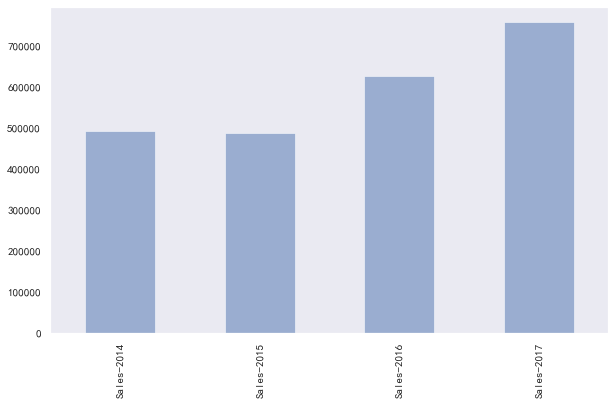

,sum_sales,rise_rate
Sales-2014,492756.6081,0.000000
Sales-2015,486629.3090,-0.012435
Sales-2016,627634.9800,0.289760
Sales-2017,757108.1332,0.206287


In [15]:
# 计算年度销售额并可视化
plt.figure(figsize = (10, 6))
sum_sales = sales.sum()
sum_sales.plot(kind='bar', alpha=0.5)
plt.grid()
plt.show()

# 计算年销售额增长率
rise_12 = sum_sales[1]/sum_sales[0]-1
rise_13 = sum_sales[2]/sum_sales[1]-1
rise_14 = sum_sales[3]/sum_sales[2]-1
rise_rate = [0, rise_12, rise_13, rise_14]
sum_sales = pd.DataFrame({'sum_sales':sum_sales})
sum_sales['rise_rate'] = rise_rate
sum_sales

上述分析结果表明：2015年销售额基本保持不变，在2016、2017年销售额增长率分别为28.98%、20.63%，发展势头良好。通过结合年度销售额及其增长率，以及企业接下来的总体布局，可对下一年度销售额目标进行规划。

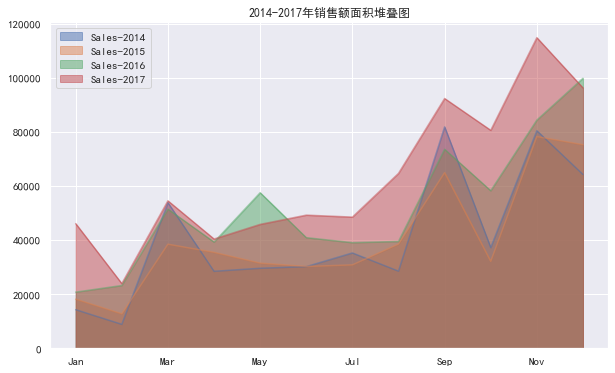

In [16]:
# 2014-2017销售额面积堆叠图
sales.plot(kind = "area", 
           figsize = (10, 6), 
           stacked = False, 
           title = "2014-2017年销售额面积堆叠图")

上图表明：该超市销售额存在季节性波动，总体呈波动上升趋势，造成上半年淡季、下半年旺季的情况。

对此可采取：
* 对于旺季的月份，运营推广等策略要继续维持，还可以加大投入，提高整体销售额。
* 对于淡季的月份，可结合部分商品特色进行新商品开发，举办特色促销活动等吸引客户。

### 销售量分析

In [17]:
Quantity = pd.concat([year_2014['Quantity'], year_2015['Quantity'], 
                      year_2016['Quantity'], year_2017['Quantity']], axis=1)

Quantity.columns = ['Quantity-2014', 'Quantity-2015', 
                    'Quantity-2016', 'Quantity-2017']

Quantity.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

Quantity.style.background_gradient()

,Quantity-2014,Quantity-2015,Quantity-2016,Quantity-2017
Jan,284,236,395,637
Feb,221,260,306,405
Mar,561,507,584,836
Apr,534,555,635,731
May,527,594,872,963
Jun,486,532,783,916
Jul,567,573,783,850
Aug,623,626,756,924
Sep,993,1099,1315,1709
Oct,660,639,756,1178


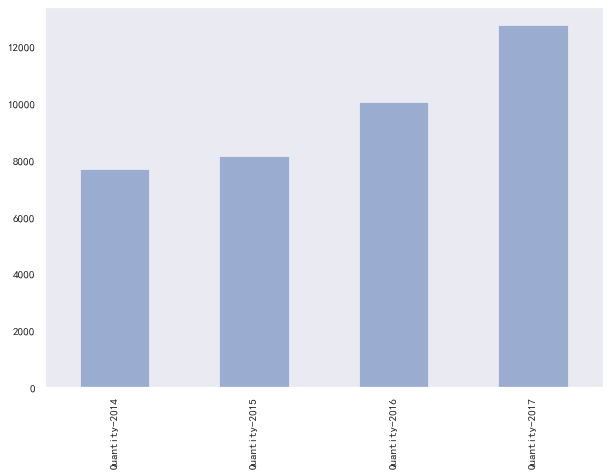

,quantity_sum,rise_rate
Quantity-2014,7691,0.000000
Quantity-2015,8169,0.062151
Quantity-2016,10067,0.232342
Quantity-2017,12779,0.269395


In [18]:
# 计算年销售量并可视化
plt.figure(figsize = (10, 7))
sum_quantity = Quantity.sum()
sum_quantity.plot(kind='bar',alpha=0.5)
plt.grid()
plt.show()

# 计算每年增长率
rise_15 = sum_quantity[1]/sum_quantity[0]-1
rise_16 = sum_quantity[2]/sum_quantity[1]-1
rise_17 = sum_quantity[3]/sum_quantity[2]-1
rise_rate = [0, rise_15, rise_16, rise_17]

sum_quantity = pd.DataFrame({'quantity_sum':sum_quantity})
sum_quantity['rise_rate'] = rise_rate
sum_quantity

上述分析结果表明：年销售量增长趋势与年销售额趋势基本一致，呈现逐年上升趋势，且下半年销售量整体高于上半年。

### 利润分析

In [19]:
profit = pd.concat([year_2014['Profit'], year_2015['Profit'], 
                    year_2016['Profit'], year_2017['Profit']], axis=1)
profit.columns = ['Profit-2014', 'Profit-2015', 
                  'Profit-2016', 'Profit-2017']
profit.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

profit.style.background_gradient()

,Profit-2014,Profit-2015,Profit-2016,Profit-2017
Jan,2455.591100,-3281.007000,3288.203300,7704.882600
Feb,1079.736600,2943.736200,5147.656700,2845.997800
Mar,841.690900,9730.702400,3710.081500,13138.409900
Apr,3517.825600,4290.336200,2960.454600,2877.790800
May,4393.430500,5068.939000,8775.316400,6316.487800
Jun,3546.086700,5555.857200,4885.354500,8367.988400
Jul,-266.330800,3915.138300,4587.090200,6651.637100
Aug,5417.820200,5751.208400,4406.303400,9431.718600
Sep,8379.469200,8284.732700,9568.481000,11942.369400
Oct,4282.711400,3042.936000,16231.679700,10125.200800


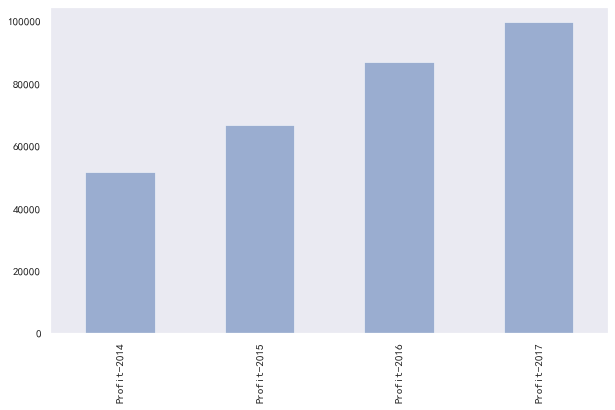

,sum_profit,year,sum_sales,profit_rate
0,51351.0541,2014,492756.6081,0.104212
1,66506.4437,2015,486629.3090,0.136668
2,86856.3908,2016,627634.9800,0.138387
3,99500.5231,2017,757108.1332,0.131422


In [20]:
# 计算年总利润并可视化
plt.figure(figsize = (10, 6))
sum_profit = profit.sum()
sum_profit.plot(kind='bar', alpha=0.5)
plt.grid()
plt.show()

sum_profit = pd.DataFrame({'sum_profit':sum_profit})
sum_profit["year"] = [2014, 2015, 2016, 2017]

sum_sales = pd.DataFrame({'sum_sales':sales.sum()})
sum_sales["year"] = [2014, 2015, 2016, 2017]

sum_profit = pd.merge(sum_profit, sum_sales)
sum_profit["profit_rate"] = sum_profit["sum_profit"]/sum_profit["sum_sales"]
sum_profit

上述分析结果表明，该超市在北美地区的年利润呈两位数逐年增长，利润率总体平稳，稳定在10%-14%之间。

### 客单价分析
---
总消费次数：同一天内，同一个人发生的所有消费算作一次消费。

客单价=总消费金额 / 总消费次数

In [21]:
for i in range(2014, 2018):
    data1 = data[data['year']==i]
    price = data1[['Order_Date', 'Customer_ID', 'Sales']]

    # 总消费次数
    price_dr=price.drop_duplicates(
        subset=['Order_Date', 'Customer_ID'])

    total_num=price_dr.shape[0]
    print('{}年总消费次数为'.format(i), total_num)

    unit_price = price['Sales'].sum()/total_num
    print('{}年客单价为'.format(i), unit_price, '\n')

2014年总消费次数为 1005
2014年客单价为 490.3050826865672 

2015年总消费次数为 1086
2015年客单价为 448.09328637200736 

2016年总消费次数为 1368
2016年客单价为 458.7975 

2017年总消费次数为 1753
2017年客单价为 431.89283126069597 



上述分析结果表明，每年的消费次数呈上升趋势，但客单价总体逐年呈下降趋势。

### 地区分析

In [22]:
Region_Year_Sales = data.groupby(['Region', 'year']).agg({'Sales':'sum'}).reset_index()
Region_Year_Sales = Region_Year_Sales.rename(columns = {'Sales':'Sales_Amounts'})
Region_Year_Sales

,Region,year,Sales_Amounts
0,Canada,2014,8509.1100
1,Canada,2015,16096.8000
2,Canada,2016,19161.1500
3,Canada,2017,23161.1100
4,Central US,2014,103838.1646
5,Central US,2015,102874.2220
6,Central US,2016,147429.3760
7,Central US,2017,147098.1282
8,Eastern US,2014,128680.4570
9,Eastern US,2015,156332.0570


Text(0.5, 1.0, '2014-2017 Region Sales')

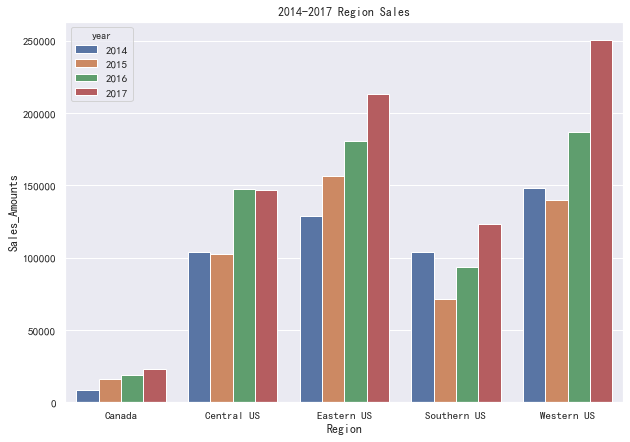

In [23]:
# 对各地区年销售额进行可视化
plt.figure(figsize = (10, 7))
sns.barplot(x='Region', 
            y='Sales_Amounts', 
            hue='year', 
            data = Region_Year_Sales)
plt.title('2014-2017 Region Sales')

In [24]:
# 四年来各个地区销售额占总销售额的百分比
Region_Sales = data.groupby(['Region']).agg({'Sales':'sum'})
Region_Sales["Percent"] = Region_Sales["Sales"] / data["Sales"].sum()
Region_Sales.style.background_gradient()

,Sales,Percent
Region,,
Canada,66928.170000,0.028310
Central US,501239.890800,0.212019
Eastern US,678781.240000,0.287117
Southern US,391721.905000,0.165694
Western US,725457.824500,0.306861


上述分析结果表明，在北美，加拿大的销售额占比微乎其微，仅占2.83%，美国划分的四个地区中，东部地区和西地区占比最高，这与其发达的经济相吻合。

## 商品分析

In [25]:
# 销售量前十的商品
productId_count = data.groupby('Product_ID').count()['Customer_ID'].sort_values(ascending=False)
print(productId_count.head(10))

Product_ID
OFF-FA-6129    227
OFF-BI-3302     20
FUR-TA-4943     18
OFF-BI-6209     17
FUR-CH-6016     15
TEC-AC-5094     15
FUR-FU-4109     14
FUR-CH-4412     14
FUR-CH-4429     14
OFF-BI-4355     14
Name: Customer_ID, dtype: int64


In [26]:
# 销售额前十的商品
productId_amount = data.groupby('Product_ID').sum()['Sales'].sort_values(ascending=False)
print(productId_amount.head(10))

Product_ID
TEC-CO-3691    61599.824
OFF-BI-4276    27453.384
TEC-MA-3819    22638.480
FUR-CH-4623    21870.576
OFF-BI-4343    19823.479
OFF-BI-4345    19024.500
TEC-CO-4585    18839.686
TEC-MA-4768    18374.895
OFF-BI-4340    17965.068
OFF-SU-4601    17030.312
Name: Sales, dtype: float64


In [27]:
# 利润前十的商品
productId_Profit= data.groupby('Product_ID').sum()['Profit'].sort_values(ascending=False)
print(productId_Profit.head(10))

Product_ID
TEC-CO-3691    25199.9280
OFF-BI-4276     7753.0390
TEC-CO-4585     6983.8836
TEC-CO-3698     4570.9347
TEC-MA-4768     4094.9766
TEC-MA-3173     3772.9461
TEC-MA-2865     3717.9714
TEC-AC-5610     3696.2820
OFF-BI-4821     3345.2823
TEC-MA-6633     3343.5360
Name: Profit, dtype: float64


上述分析结果表明，销售量前十的商品基本为办公类和家具类商品；而销售额前十的商品基本为电子类、办公类商品；利润前十的商品大部分是电子类产品，考虑到电子类商品的特性，可将电子产品作为推销重点，以提高其销量，从而增加整体的利润。

In [28]:
# 根据商品种类和子种类，合成一个新的种类
data['Category_Sub_Category'] = data[['Category', 'Sub_Category']].apply(
    lambda x:str(x[0])+'_'+str(x[1]), axis=1)
# 按照新的种类进行分组，统计销售额和利润
Category_Sub_Category = data.groupby("Category_Sub_Category").agg(
    {"Profit":"sum", "Sales":"sum"}).reset_index()
# 按照销售额倒序排序
Category_Sub_Category.sort_values(
    by=["Sales"], ascending=False, inplace=True)
# 每个种类商品的销售额累计占比
Category_Sub_Category['Cum_Percent'] = Category_Sub_Category['Sales'].cumsum()/Category_Sub_Category['Sales'].sum()
Category_Sub_Category

,Category_Sub_Category,Profit,Sales,Cum_Percent
16,Technology_Phones,47195.6006,340092.6640,0.143855
1,Furniture_Chairs,27446.9063,331652.4730,0.284141
11,Office Supplies_Storage,24146.4472,234158.0160,0.383187
3,Furniture_Tables,-17425.3011,207814.8920,0.471090
6,Office Supplies_Binders,30991.2489,206459.9610,0.558420
15,Technology_Machines,3992.5569,193513.0910,0.640274
13,Technology_Accessories,43231.9457,171853.5280,0.712966
14,Technology_Copiers,58281.4649,156993.5600,0.779373
0,Furniture_Bookcases,-2130.0260,120614.0163,0.830391
4,Office Supplies_Appliances,20253.9837,114943.8110,0.879011


从上述分析结果表中，可以清晰看到不同种类商品的销售额贡献对比，前一半商品的总销售占比已经超过80%。同时发现，排在末尾6个种类的商品为办公类商品，这可以考虑与其他主营商品结合，连带销售来提升销量，或者考虑对这些商品进行优化。值得关注的是，Tables(桌子)为负利润，说明这一商品目前处于亏损状态，通过查看原数据，发现Tabels大部分都在打折，存在促销活动让利过多导致利润为负。

## 客户分析

### 不同类型的客户占比

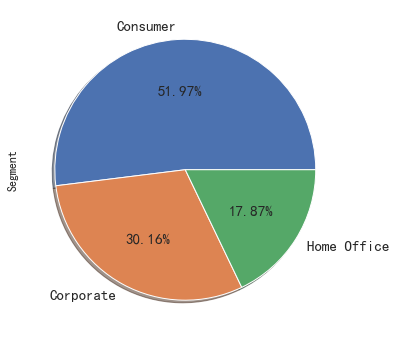

In [29]:
data["Segment"].value_counts().plot(kind='pie', 
                                    autopct='%.2f%%', 
                                    shadow=True, 
                                    fontsize = 15, 
                                    figsize=(14, 6))

饼图表明：个人消费客户占比最多，达到51.97%，表明个人消费为该超市主要消费群体。

Text(0.5, 1.0, '2014-2017 Segment Customer')

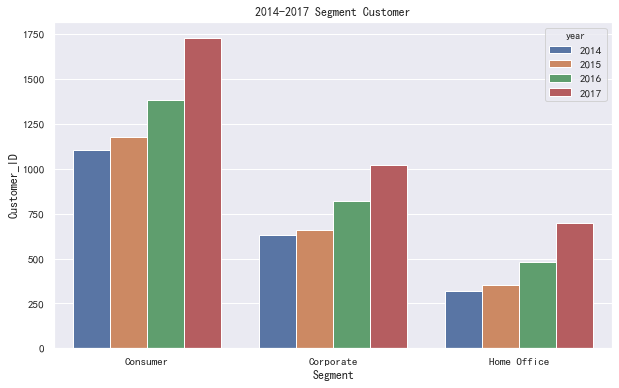

In [30]:
# 查看每一年不同类型的客户数量
Segment_Year = data.groupby(["Segment", 'year']).agg(
    {'Customer_ID':'count'}).reset_index()
plt.figure(figsize = (10, 6))
sns.barplot(x='Segment', 
            y='Customer_ID', 
            hue='year', 
            data = Segment_Year)
plt.title('2014-2017 Segment Customer')

从上面可以看出，每类客户每年都呈现出增长趋势。

Text(0.5, 1.0, '2014-2017 Segment Sales')

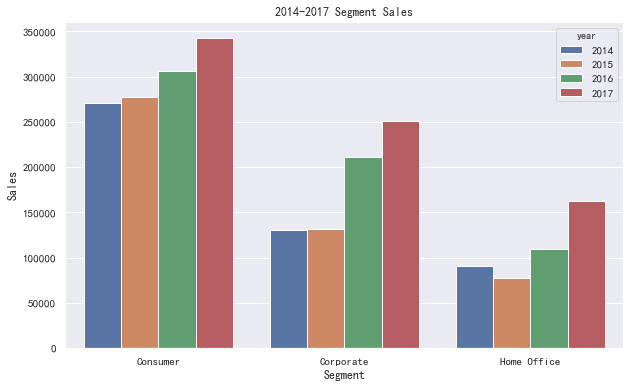

In [31]:
# 查看不同类型的客户每年贡献的销售额
Segment_sales = data.groupby(["Segment", 'year']).agg(
    {'Sales':'sum'}).reset_index()
plt.figure(figsize = (10, 6))
sns.barplot(x='Segment', 
            y='Sales', 
            hue='year', 
            data = Segment_sales)
plt.title('2014-2017 Segment Sales')

各个类型的客户每年贡献的销售额大致呈现稳步增长趋势

### 客户下单行为分析

In [32]:
# 取Customer_ID, Order_Date, Quantity, Sales, month构建新数据
grouped_Customer = data[['Customer_ID','Order_Date', 'Quantity', 'Sales', 'month']]
grouped_Customer = grouped_Customer.sort_values(['Order_Date']).groupby('Customer_ID')
grouped_Customer.head()

,Customer_ID,Order_Date,Quantity,Sales,month
50469,MM-726023,2014-01-02,1,314.220,2014-01-01
48149,DP-130001402,2014-01-04,2,16.448,2014-01-01
40910,PO-191951402,2014-01-05,2,3.540,2014-01-01
40908,PO-191951402,2014-01-05,3,11.784,2014-01-01
40909,PO-191951402,2014-01-05,3,272.736,2014-01-01
...,...,...,...,...,...
41076,PO-188651406,2017-12-31,7,90.930,2017-12-01
41075,PO-188651406,2017-12-31,4,323.136,2017-12-01
40814,CC-124301402,2017-12-31,2,209.300,2017-12-01
41465,EB-139751404,2017-12-31,2,13.904,2017-12-01


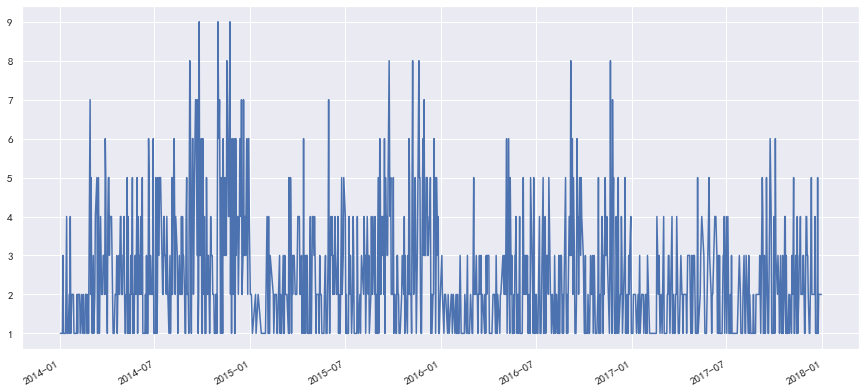

In [33]:
# 查看客户第一次购买的时间序列分布
grouped_Customer.min().Order_Date.value_counts().plot(figsize = (15, 7))

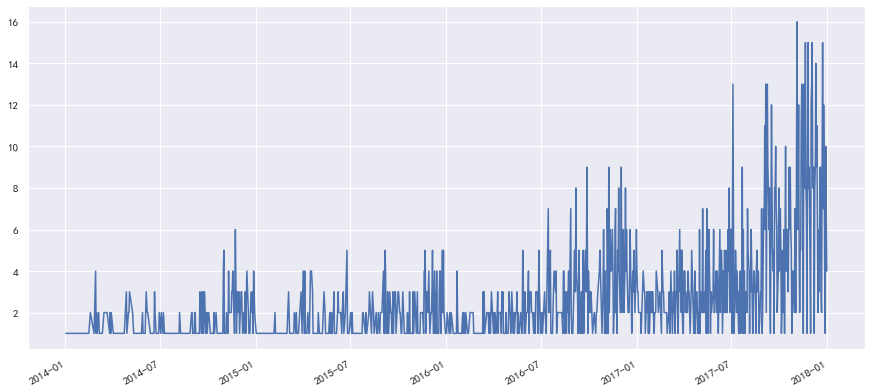

In [34]:
# 查看客户最近一次购买的时间序列分布
grouped_Customer.max().Order_Date.value_counts().plot(figsize = (15, 7))

从客户第一次购买的时间序列分布图可发现新客户数量总体呈现出缓慢下降的趋势，商场可以通过广告等推广策略吸收更多的新客户；从客户最近一次购买的时间序列分布图可发现用户基本没有流失，呈现逐年递增的趋势。

### RFM模型分析

In [35]:
# 构建RFM数据
rfm = data.pivot_table(index = 'Customer_ID', 
                       values = ["Order_ID", 
                                 "Sales", 
                                 "Order_Date"], 
                       aggfunc = {"Order_ID":"count", 
                                  "Sales":"sum", 
                                  "Order_Date":"max"})
rfm['R'] = (rfm.Order_Date.max()-rfm.Order_Date)/np.timedelta64(1, 'D')
rfm.rename(columns = {'Order_ID':'F', 'Sales':'M'}, inplace = True)
rfm.head()

,Order_Date,F,M,R
Customer_ID,,,,
AA-103151402,2017-06-30,6,4780.552,184.0
AA-103151404,2015-10-04,3,753.508,819.0
AA-103151406,2014-09-14,2,29.500,1204.0
AA-103751402,2015-02-02,2,178.370,1063.0
AA-103751404,2016-07-11,4,72.808,538.0


In [36]:
# 基于平均值做比较，超过均值的设为1，反之为0
rfm[['R', 'F', 'M']].apply(lambda x:x-x.mean())

def rfm_model(x):
    level = x.apply(lambda x:'1' if x>0 else '0')
    level = level.R+level.F+level.M
    client = {"111":"重要价值客户", 
              "011":"重要保持客户", 
              "101":"重要挽留客户", 
              "001":"重要发展客户", 
              "110":"一般价值客户", 
              "010":"一般保持客户", 
              "100":"一般挽留客户", 
              "000":"一般发展客户"}
    result = client[level]
    return result

In [37]:
rfm['label'] = rfm[['R', 'F', 'M']].apply(lambda x:x-x.mean()).apply(rfm_model, axis=1)
rfm.head()

,Order_Date,F,M,R,label
Customer_ID,,,,,
AA-103151402,2017-06-30,6,4780.552,184.0,重要保持客户
AA-103151404,2015-10-04,3,753.508,819.0,一般挽留客户
AA-103151406,2014-09-14,2,29.500,1204.0,一般挽留客户
AA-103751402,2015-02-02,2,178.370,1063.0,一般挽留客户
AA-103751404,2016-07-11,4,72.808,538.0,一般价值客户


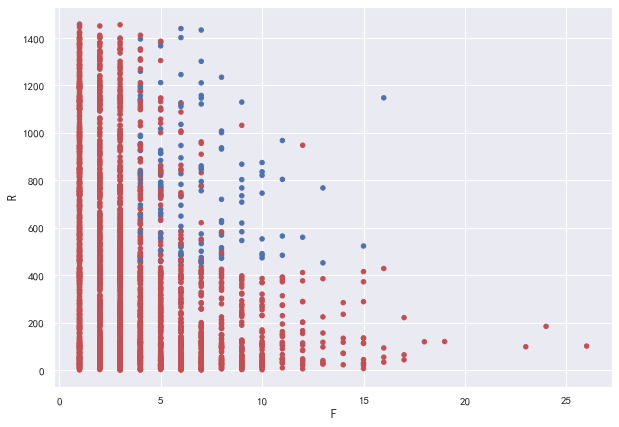

In [38]:
# 对重要价值客户和非重要价值客户进行可视化
rfm.loc[rfm.label=='重要价值客户', 'color'] = 'b'
rfm.loc[~(rfm.label=='重要价值客户'), 'color']='r'
rfm.plot.scatter('F', 'R', c = rfm.color, figsize = (10, 7))

通过RFM识别不同的客户群体，能够衡量客户价值和客户利润创收能力，可以指定个性化的沟通和营销服务，为更多的营销决策提供有力支持，为企业创造更大的利益。

### 新客户、活跃客户、不活跃客户和回归客户分析

In [39]:
# 设置Customer_ID为索引，month为列名，统计每个月的购买次数
pivoted_counts = data.pivot_table(index = 'Customer_ID', 
                                  columns = 'month', 
                                  values = 'Order_Date', 
                                  aggfunc = 'count')
pivoted_counts = pivoted_counts.fillna(0)
df_purchase = pivoted_counts.applymap(lambda x:1 if x>0 else 0)
df_purchase.head()

month,2014-01-01,2014-02-01,2014-03-01,2014-04-01,2014-05-01,2014-06-01,2014-07-01,2014-08-01,2014-09-01,2014-10-01,...,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01
Customer_ID,,,,,,,,,,,,,,,,,,,,,
AA-103151402,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
AA-103151404,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AA-103151406,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
AA-103751402,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AA-103751404,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [40]:
def active_status(data):
    status = []
    for i in range(48):
        if data[i] == 0:
            if len(status)>0:
                if status[i-1] == "Unregistered":
                    # Unregistered Customer
                    status.append("Unregistered")
                else:
                    # Inactive Customer
                    status.append("Inactive")
            else:
                status.append("Unregistered")
            
        # consumption
        else:
            if len(status) == 0:
                # New Customer
                status.append("New")
            else:
                if status[i-1] == "Inactive":
                    # Return Customer
                    status.append("Return")
                elif status[i-1] == "Unregistered":
                    status.append("New")
                else:
                    status.append("Active")
    return pd.Series(status)

In [41]:
purchase_stats = df_purchase.apply(active_status, axis =1)
purchase_stats.head()

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
Customer_ID,,,,,,,,,,,,,,,,,,,,,
AA-103151402,Unregistered,Unregistered,Unregistered,Unregistered,Unregistered,Unregistered,Unregistered,Unregistered,Unregistered,Unregistered,...,Inactive,Inactive,Inactive,Return,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive
AA-103151404,Unregistered,Unregistered,New,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,...,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive
AA-103151406,Unregistered,Unregistered,Unregistered,Unregistered,Unregistered,Unregistered,Unregistered,Unregistered,New,Inactive,...,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive
AA-103751402,Unregistered,Unregistered,Unregistered,Unregistered,Unregistered,Unregistered,Unregistered,Unregistered,Unregistered,Unregistered,...,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive
AA-103751404,Unregistered,Unregistered,Unregistered,New,Inactive,Inactive,Inactive,Inactive,Inactive,Return,...,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive


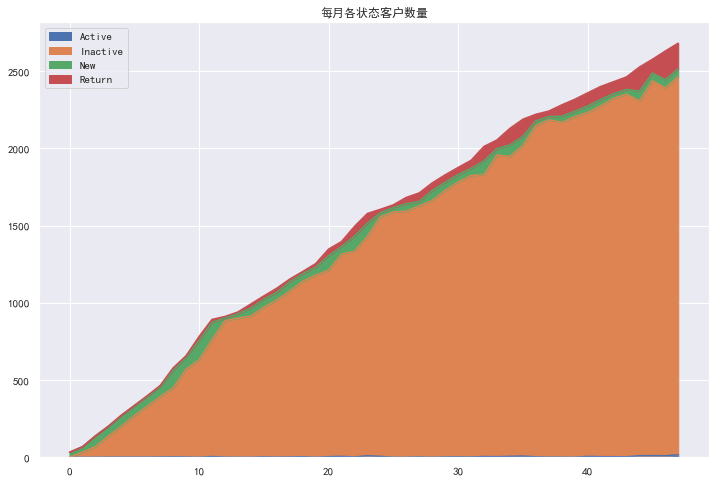

In [42]:
# 用NaN替代“Unregistered”
purchase_stats_ct = purchase_stats.replace(
    'Unregistered', np.NaN).apply(lambda x:pd.value_counts(x))
# 用0填充NaN
purchase_stats_ct.fillna(0).T.plot(kind = "area", 
                                   title = "每月各状态客户数量", 
                                   figsize = (12, 8))

### 复购率和回购率分析
---
* 复购：客户在一个月内购买过多次算复购。
* 回购：客户在该月已有购买，且在下月也购买则计入回购。

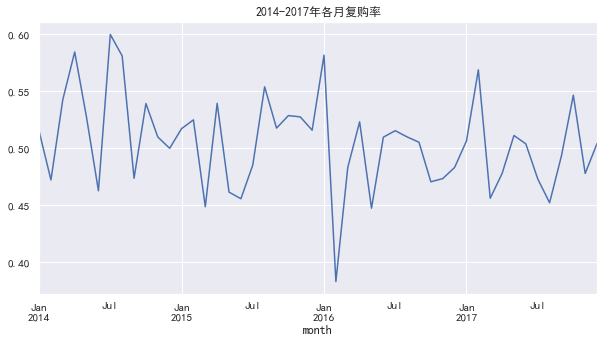

In [43]:
Repurchase = pivoted_counts.applymap(lambda x:1 if x>1 else np.NaN if x==0 else 0)
(Repurchase.sum()/Repurchase.count()).plot(figsize=(10, 5), title = "2014-2017年各月复购率")

In [44]:
def Repurchase_back(data):
    status=[]
    for i in range(47):
        if data[i] == 1:
            if data[i+1] == 1:
                status.append(1)
            if data[i+1] == 0:
                status.append(0)
        else:
            status.append(np.NaN)
    status.append(np.NaN)
    return status

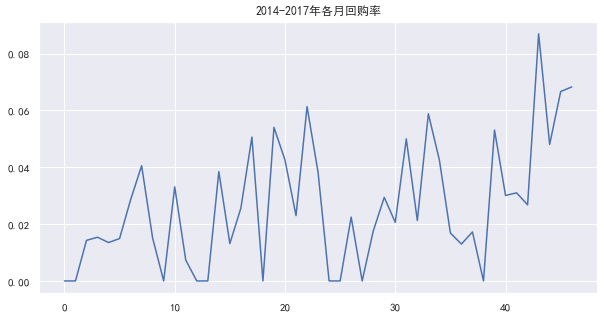

In [45]:
Repurchase_b = df_purchase.apply(Repurchase_back, result_type='expand', axis =1)
(Repurchase_b.sum()/Repurchase_b.count()).plot(figsize=(10,5), title = "2014-2017年各月回购率")

从复购率的分析结果图可发现复购率基本在0.5附近波动，这说明客户在月内多次采购的概率还是较高的，也从侧面反映客户忠诚度较稳定。从回购率的分析结果图可发现，回购率呈周期性波动，但总体趋势向好。

---